# Import Libraries & Set Up
---

In [1]:
import warnings
import logging
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import bnlearn as bn
from pgmpy.global_vars import logger
from utils import * # Helper functions

In [2]:
warnings.filterwarnings('ignore')
logger.setLevel(logging.ERROR)
logging.getLogger('seaborn').setLevel(logging.ERROR)
logging.getLogger('matplotlib').setLevel(logging.ERROR)
logging.getLogger('pandas').setLevel(logging.ERROR)

palette = ['#800080', '#8A2BE2', '#FF69B4', '#DA70D6', '#9370DB', '#DDA0DD', '#BA55D3']
gradient_palette = sns.light_palette('#620080', as_cmap=True)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)
sns.set_theme(style="whitegrid", palette=palette)

# Dementia
---

Let's import the processed dataset.

In [3]:
dementia_df = pd.read_csv('data/dementia_data_processed.csv')

## Discretising the Data
---

To prepare the data for a discrete BN, we must first discretise the data into bins.

In [4]:
dementia_df_5bins = discretise(dementia_df.copy(), nbins=5)
dementia_df_sturges = discretise(dementia_df.copy(), method='sturges')
dementia_df_freedman_diaconis = discretise(dementia_df.copy(), method='freedman-diaconis')

Then we can plot this discretised data to see the effects.

### 5 Bin Discretisation
---

In [5]:
dementia_df_5bins.head()

,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0,0,0,0,3,2,1,4,0,4,1,0
1,0,1,0,0,3,2,1,4,0,4,0,0
2,1,0,0,0,1,1,0,3,0,3,2,1
3,1,1,1,0,2,1,0,4,0,3,1,0
4,1,2,3,0,2,1,1,3,0,3,1,1


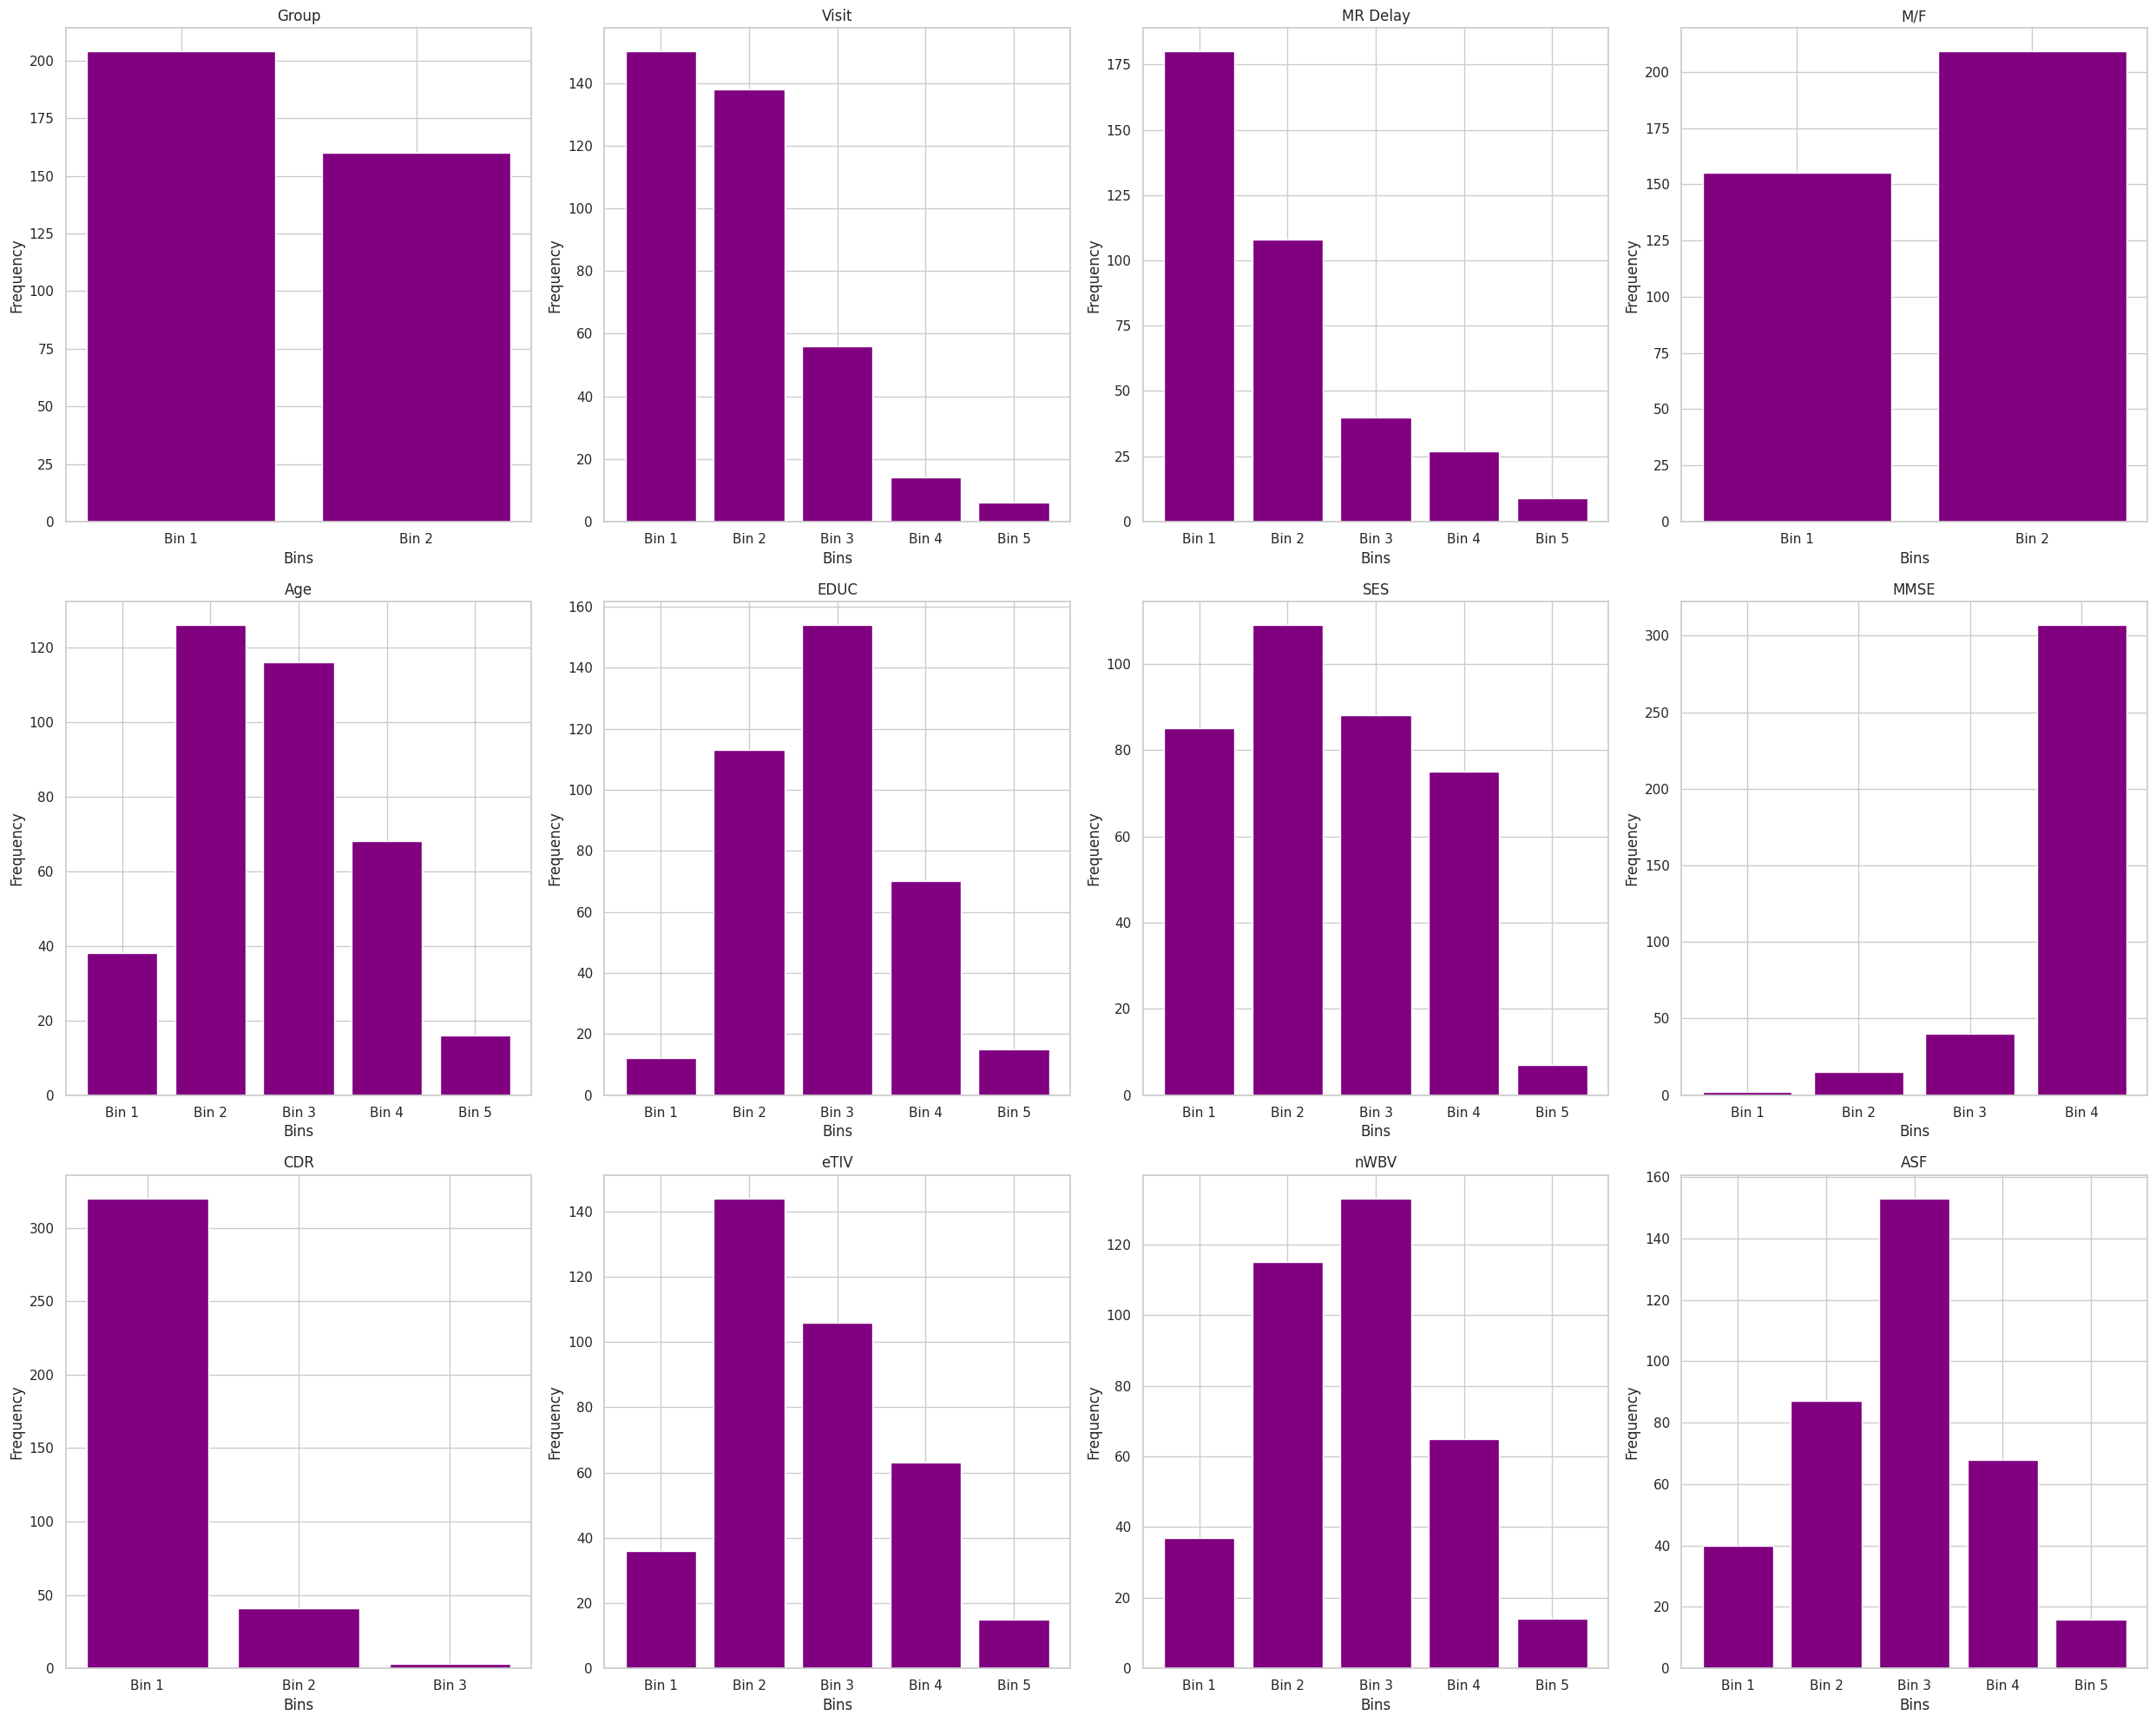

In [6]:
plot_bins_barcharts(dementia_df_5bins)

### Sturges Formula Discretisation
---

In [7]:
dementia_df_sturges.head()

,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0,0,0,0,7,4,2,8,0,9,2,0
1,0,1,1,0,7,4,2,9,0,9,1,0
2,1,0,0,0,3,3,1,7,0,6,4,2
3,1,1,2,0,4,3,1,9,0,7,3,1
4,1,2,7,0,5,3,3,6,0,6,2,2


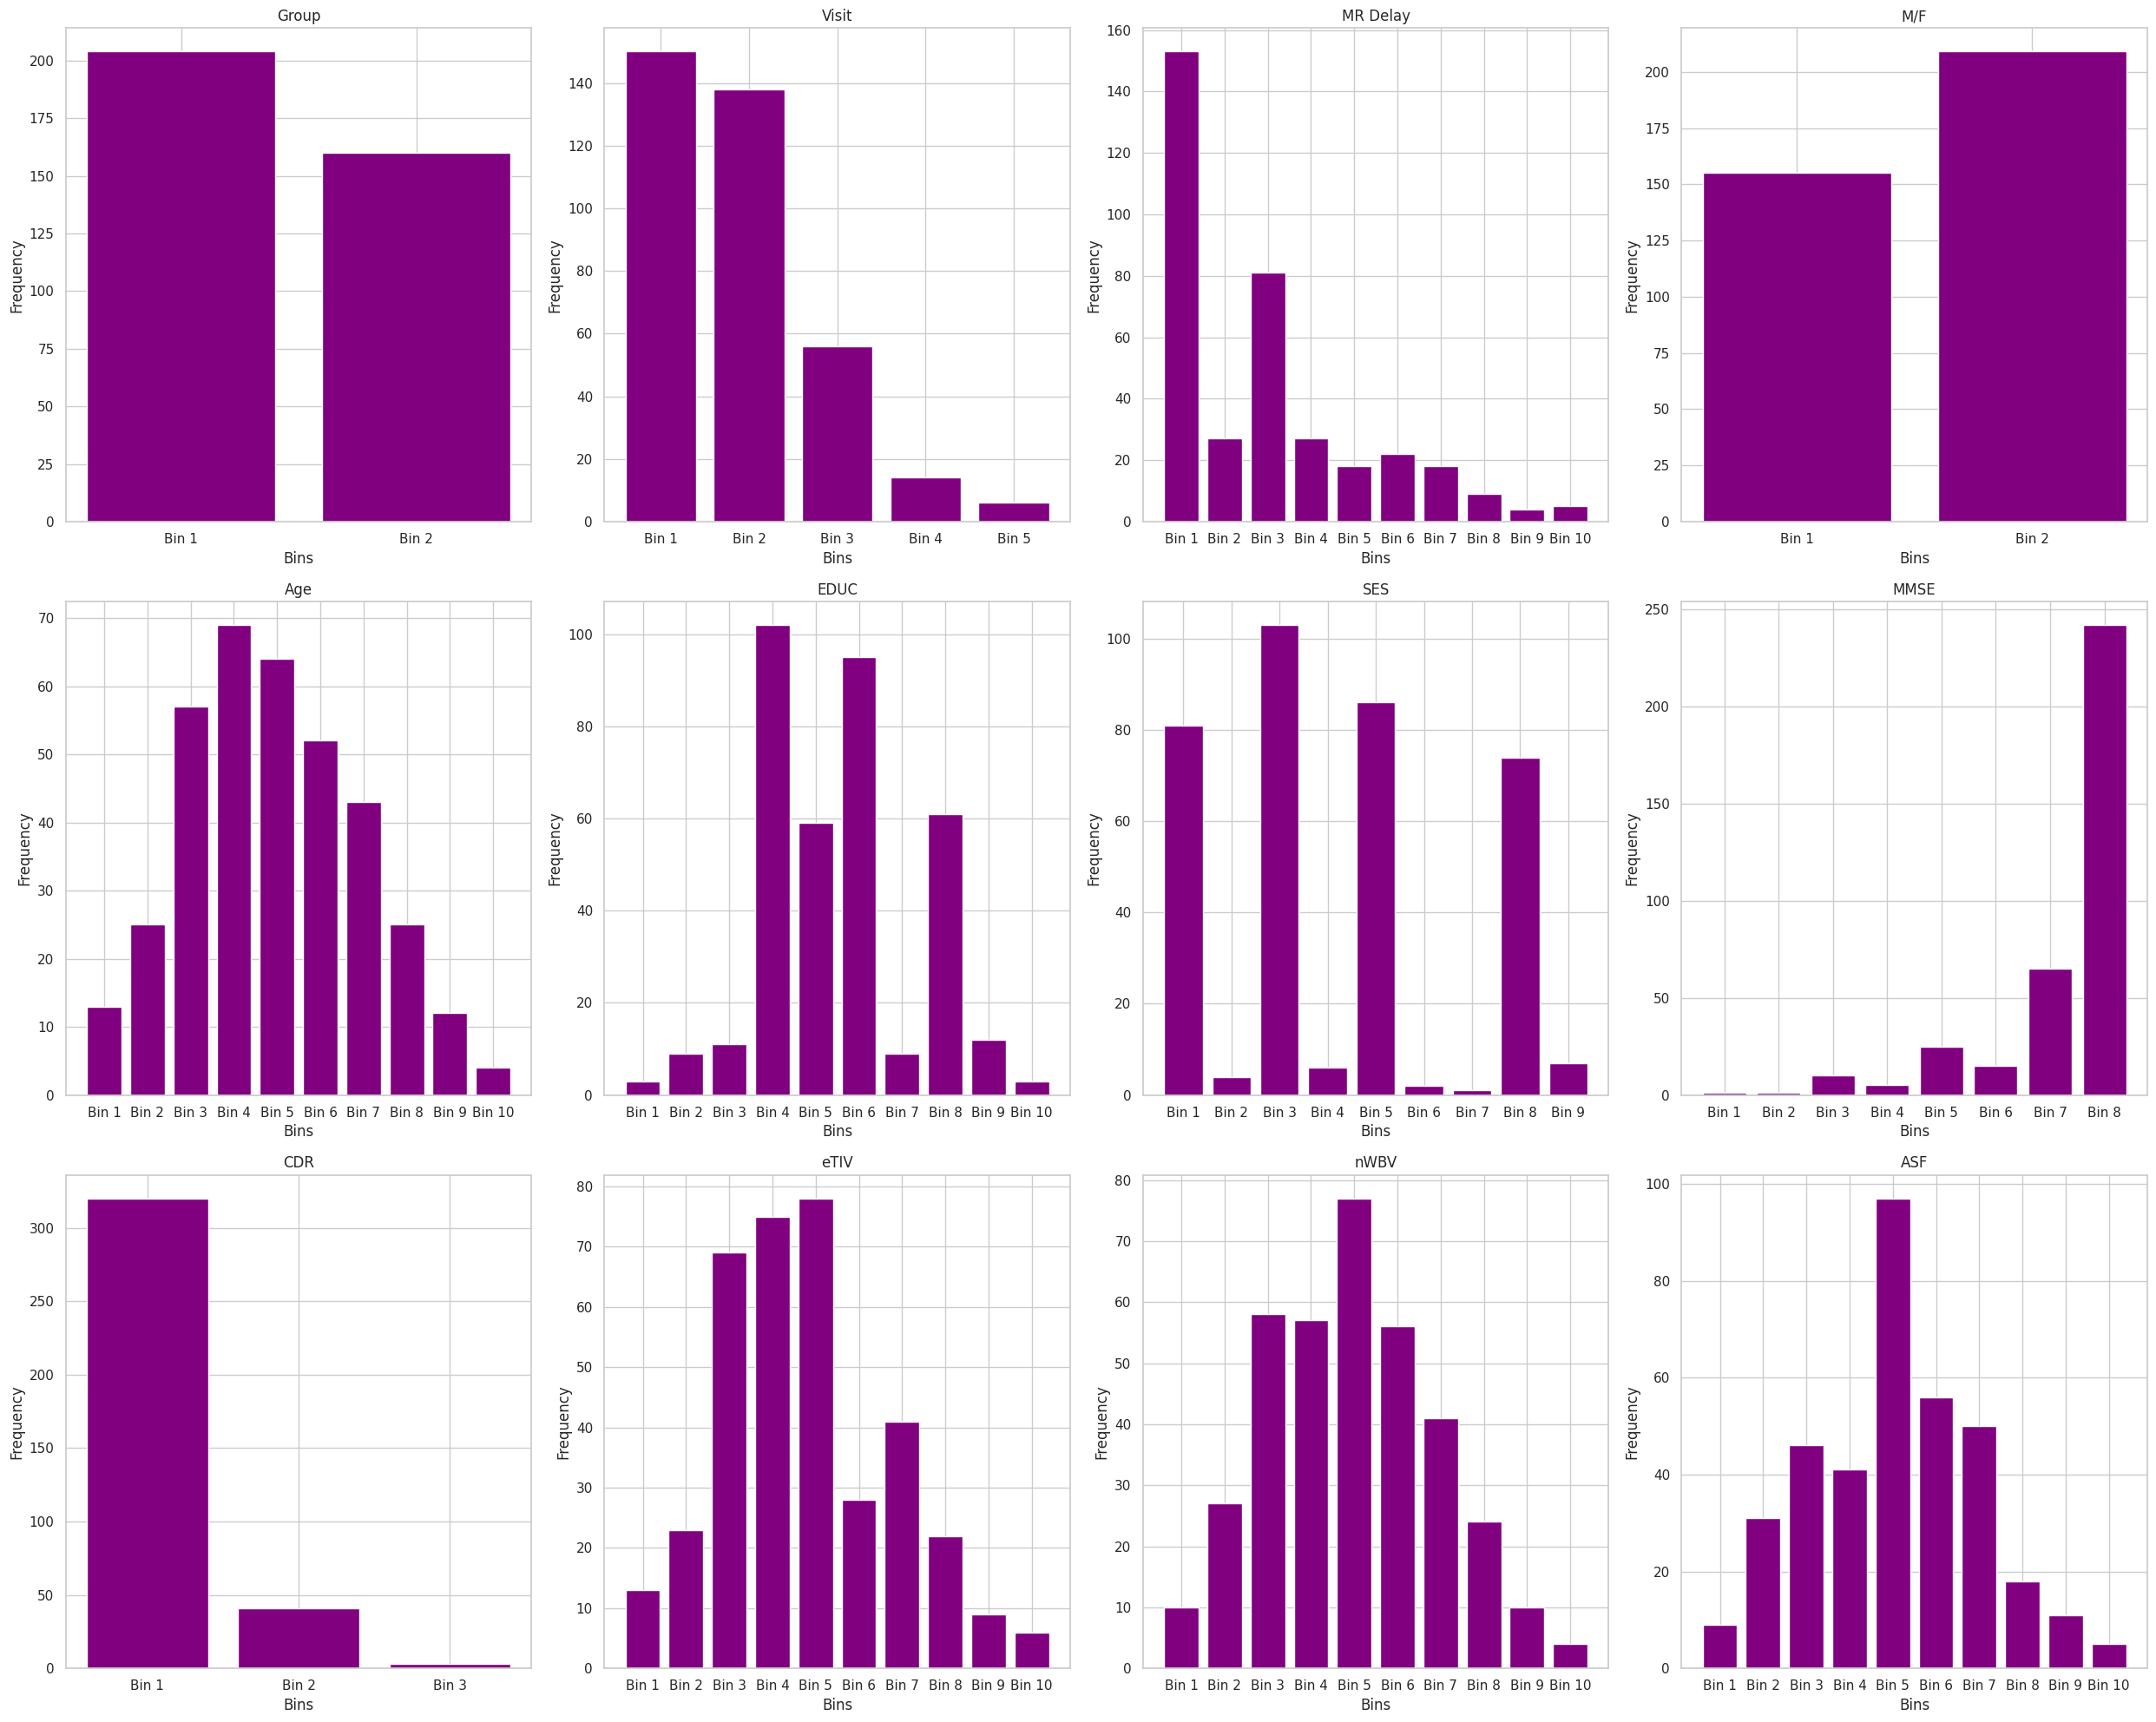

In [8]:
plot_bins_barcharts(dementia_df_sturges)

### Freedman Diaconis Rule Discretisation
---

In [9]:
dementia_df_freedman_diaconis.head()

,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0,0,0,0,9,5,3,16,0,13,3,0
1,0,1,1,0,9,5,3,18,0,13,2,0
2,1,0,0,0,5,4,2,13,0,8,6,3
3,1,1,2,0,5,4,1,17,0,9,4,2
4,1,2,7,0,6,4,5,13,0,9,3,3


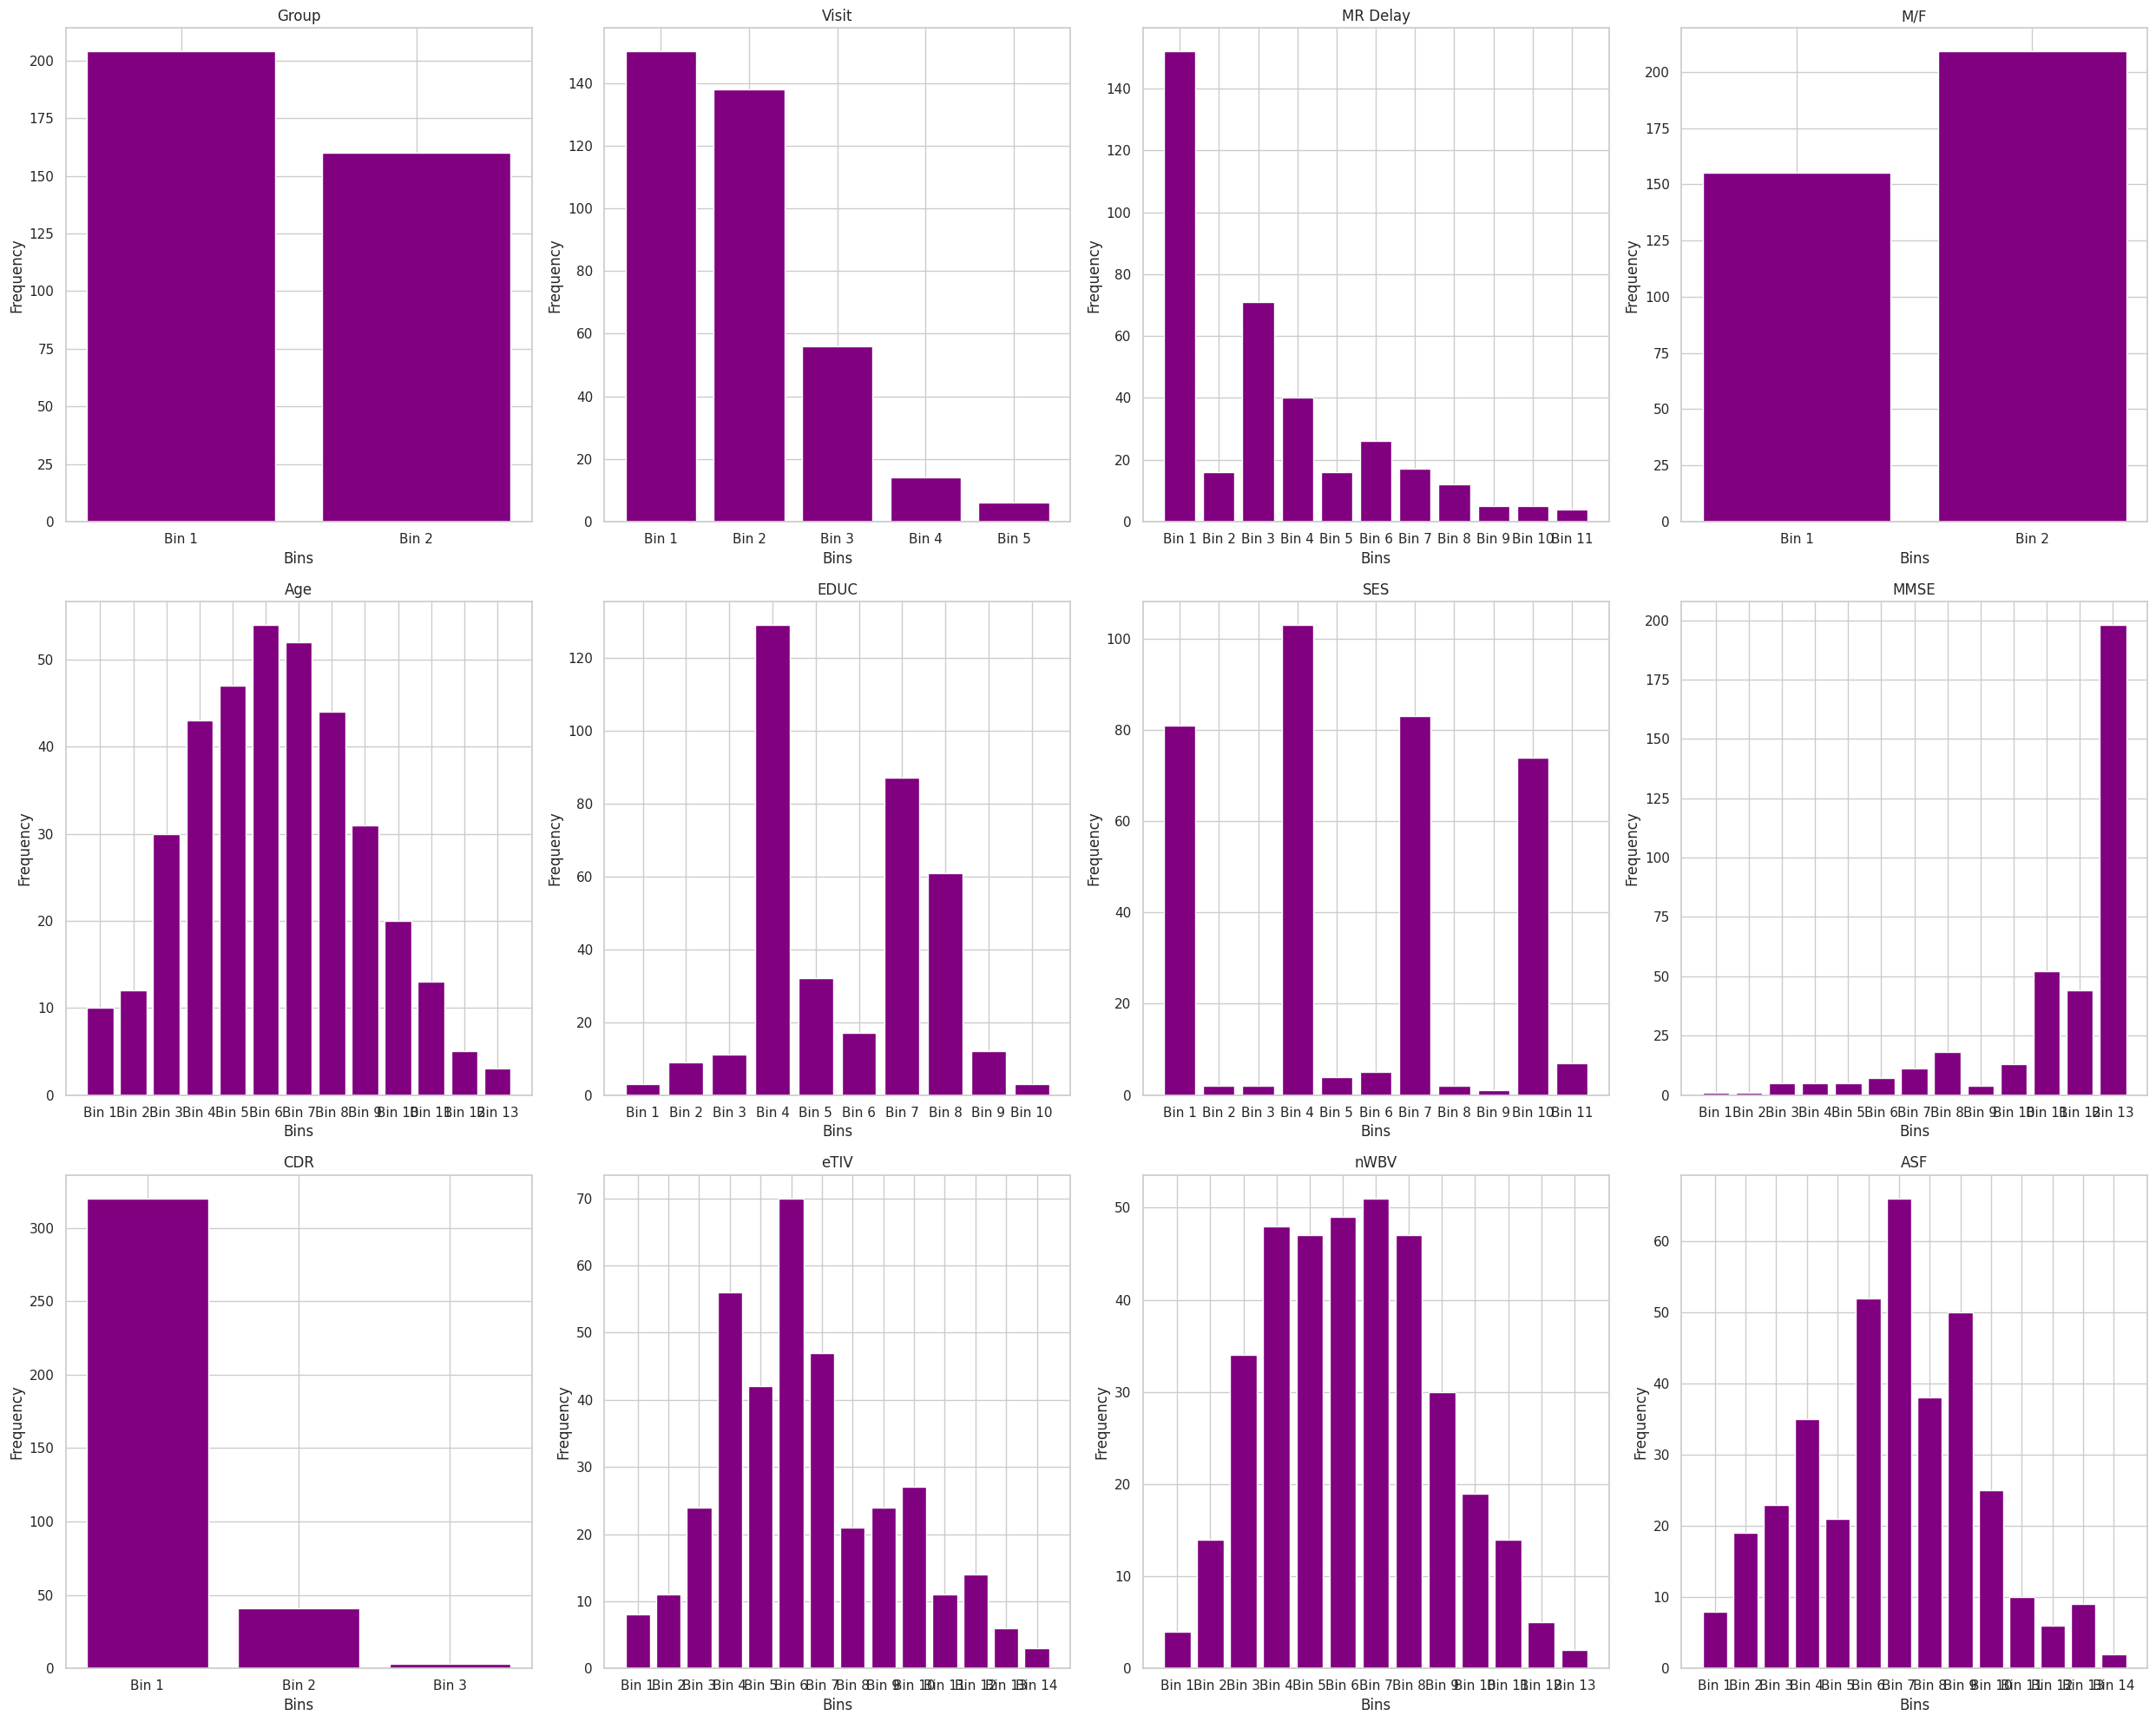

In [10]:
plot_bins_barcharts(dementia_df_freedman_diaconis)

### Comparing Discretisation Methods
---

Visually we can see that the Freedman-Diaconis Rule seemingly performs well compared to the other methods, without much extra computation needed. We can verify this by checking the Mean Squared Error (MSE) in comparison to the original, continuous data.

In [11]:
from sklearn.metrics import mean_squared_error

In [12]:
mse_5bins = mean_squared_error(dementia_df, dementia_df_5bins)
mse_sturges = mean_squared_error(dementia_df, dementia_df_sturges)
mse_freedman_diaconis = mean_squared_error(dementia_df, dementia_df_freedman_diaconis)

In [13]:
mse_values = [mse_5bins, mse_sturges, mse_freedman_diaconis]

Now we can visualise the MSE scores of each method (the lower the better).

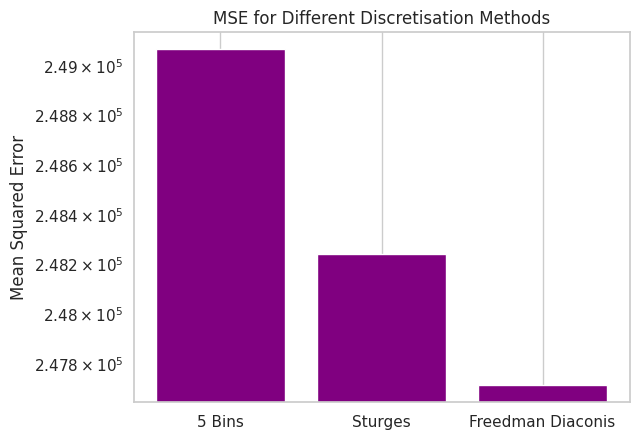

In [14]:
plt.bar(['5 Bins', 'Sturges', 'Freedman Diaconis'], mse_values)
plt.title('MSE for Different Discretisation Methods')
plt.ylabel('Mean Squared Error')
plt.yscale('log')
plt.show()

As observed, the Freedman-Diaconis method yields the best performance among the four discretisation methods. However, the significantly high MSE score suggests that discretising the data may not be the most effective approach for this dataset. This indicates that using discrete Bayesian Networks (BNs) could be introducing substantial information loss.

In [15]:
dementia_df = dementia_df_freedman_diaconis.copy()
dementia_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Group,364.0,0.439560,0.497017,0.0,0.0,0.0,1.0,1.0
Visit,364.0,0.868132,0.923627,0.0,0.0,1.0,1.0,4.0
MR Delay,364.0,2.151099,2.465570,0.0,0.0,2.0,3.0,10.0
M/F,364.0,0.574176,0.495148,0.0,0.0,1.0,1.0,1.0
Age,364.0,5.296703,2.559461,0.0,3.0,5.0,7.0,12.0
EDUC,364.0,5.653846,1.998887,0.0,4.0,5.0,7.0,11.0
SES,364.0,4.467033,3.325585,0.0,3.0,3.0,6.0,12.0
MMSE,364.0,16.414835,2.630799,0.0,16.0,18.0,18.0,18.0
CDR,364.0,0.137363,0.410375,0.0,0.0,0.0,0.0,3.0
eTIV,364.0,5.450549,2.791225,0.0,3.0,5.0,7.0,13.0


## Learning Structure & Parameters with Cross-Validation
---

Now we will explore the process of structure learning and parameter learning for Bayesian Networks (BNs) using the provided dataset. We will evaluate multiple structure learning methods, perform parameter learning, and assess the results using cross-validation.

Our goals are:
1. To understand the structure of the data using various structure learning algorithms.
2. To learn the parameters of the best structure.
3. To evaluate the performance of each method through cross-validation.

The methods we will use:
1. Tree-Augmented Naive Bayes (TAN)
2. Hill Climbing (HC) with BDeu scoring
3. PC Algorithm

We will then evaluate each method's performance and compare the results.

### Cross-Validation
---

In utils we have defined a function for cross validation, and we can run for each different type of model we want to test to see which one gets the best results.

In [16]:
metrics = {}
confusion = {}

#### Tree-Augmented Naive Bayes
---

In [17]:
structure_kwargs_tan = {'methodtype': 'tan', 'class_node': 'Group'}

##### Bayes

In [18]:
metrics_tan_bayes, confusion_tan_bayes = discrete_cross_validation(dementia_df, 'Group', structure_kwargs=structure_kwargs_tan, parameter_kwargs={'methodtype': 'bayes'})


Fold 1/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+---------------------+---------------------+
| Group    | Group(0)            | Group(1)            |
+----------+---------------------+---------------------+
| eTIV(0)  | 0.05999136814846786 | 0.06313876902112198 |
+----------+---------------------+---------------------+
| eTIV(1)  | 0.05848079413034097 | 0.06154894390188509 |
+----------+---------------------+---------------------+
| eTIV(2)  | 0.07056538627535608 | 0.0710878946173064  |
+----------+---------------------+---------------------+
| eTIV(3)  | 0.08113940440224429 | 0.090165796048149   |
+----------+---------------------+---------------------+
| eTIV(4)  | 0.0796288303841174  | 0.0806268453327277  |
+----------+---------

100%|██████████| 1/1 [00:00<00:00, 525.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 707.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 473.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 613.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 446.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 540.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 556.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 515.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 446.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 471.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 473.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 433.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 363.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 411.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 460.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 468.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 472.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 490.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 414.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 496.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 510.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 518.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 453.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 545.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 424.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 418.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 661.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 474.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 482.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 413.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 547.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 435.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 526.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 568.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 382.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 457.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 467.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 482.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 414.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 405.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 420.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 425.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 534.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 328.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 492.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 596.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 647.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 416.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 471.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 394.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 665.34it/s]

[bnlearn]> Remaining columns for inference: 11



100%|██████████| 1/1 [00:00<00:00, 509.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 687.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 590.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 512.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 469.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 563.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 484.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 490.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 526.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 398.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 439.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 597.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 512.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 494.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 496.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 605.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 443.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 458.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 526.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 563.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 564.36it/s]



Fold 2/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of ASF:
+---------+----------------------+----------------------+
| Group   | Group(0)             | Group(1)             |
+---------+----------------------+----------------------+
| ASF(0)  | 0.058304647160068855 | 0.061745272271588075 |
+---------+----------------------+----------------------+
| ASF(1)  | 0.07637693631669537  | 0.06334016860332652  |
+---------+----------------------+----------------------+
| ASF(2)  | 0.07336488812392428  | 0.06812485759854182  |
+---------+----------------------+----------------------+
| ASF(3)  | 0.07185886402753874  | 0.07609933925723401  |
+---------+----------------------+----------------------+
| ASF(4)  | 0.06282271944922549  | 0.07609933925723401  |
+---------

100%|██████████| 1/1 [00:00<00:00, 512.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 444.69it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 75 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
75      1      0         0    0    8     0    9    15    0     3     5    9
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 76 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
76      1      1         2    0    8     0    9    16    0     3     5    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 77 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
77      1      2         5    0    9     0    9    13    0     3     4    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 588.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 583.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 474.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 592.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 445.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 590.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 565.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 397.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 616.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 734.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 729.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 534.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 578.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 337.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 626.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 458.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 389.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 410.68it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 96 in fold 2: KeyError - 2
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
96      1      3         4    0    2     7    0     2    1     9     2    2
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 97 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
97      1      4         5    0    3     7    0     0    1     9     2    3
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 587.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 507.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 514.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 431.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 347.99it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 103 in fold 2: KeyError - 11
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
103      0      0         0    1   10    11    0    18    0     5     3    6
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 104 in fold 2: KeyError - 11
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
104      0      1         1    1   11    11    0    18    0     5     3    6
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 105 in fold 2: KeyError - 11
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
105      0      2         6    1   12    11    0    18    0     5     3    6
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 374.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 571.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 518.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 310.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 381.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 450.42it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 112 in fold 2: KeyError - 12
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
112      0      0         0    0    1     4    6    18    0     3    12    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 113 in fold 2: KeyError - 12
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
113      0      1         3    0    2     4    6    16    0     4    12    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 352.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 465.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 532.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 558.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 653.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 465.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 451.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 574.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 657.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 484.50it/s]

[bnlearn]> Remaining columns for inference: 11



100%|██████████| 1/1 [00:00<00:00, 671.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 638.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 391.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 497.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 559.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 495.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 415.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 465.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 559.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 605.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 355.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 407.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 448.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 345.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 282.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 447.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 594.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 345.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 447.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 572.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 419.01it/s]



Fold 3/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.057142857142857155 | 0.05976907403214853  |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.06623376623376624  | 0.061353860086031255 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.07380952380952382  | 0.07086257640932761  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.10259740259740263  | 0.0946343672175685   |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.07835497835497837  | 0.07878650667874124 

100%|██████████| 1/1 [00:00<00:00, 557.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 491.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 686.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 470.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 587.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 698.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 449.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 514.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 497.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 420.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 571.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 373.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 439.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 446.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 402.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 405.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 445.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 553.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 631.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 368.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 595.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 714.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 481.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 524.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 731.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 606.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 542.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 587.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 484.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 596.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 427.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 494.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 631.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 512.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 409.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 459.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 532.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 509.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 705.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 652.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 564.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 490.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 495.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 377.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 397.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 421.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 365.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 561.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 626.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 357.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 409.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 496.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 434.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 471.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 643.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 555.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 523.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 501.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 612.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 622.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 690.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 723.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 416.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 584.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 424.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 533.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 561.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 688.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 669.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 571.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 650.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 443.47it/s]



Fold 4/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.05671321160042966  | 0.0634413509812871   |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.0657357679914071   | 0.061843906891830225 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.0657357679914071   | 0.06983112733911458  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.09280343716433943  | 0.0842081241442264   |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.08528464017185823  | 0.07622090369694205 

100%|██████████| 1/1 [00:00<00:00, 546.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 518.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 562.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 663.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 636.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 442.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 495.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 520.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 637.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 533.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 596.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 396.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 631.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 518.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 536.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 414.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 524.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 262.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 474.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 413.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 527.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 691.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 395.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 630.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 695.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 541.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 495.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 647.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 551.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 429.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 516.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 639.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 612.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 538.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 446.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 507.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 452.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 497.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 477.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 699.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 467.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 494.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 454.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 423.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 564.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 623.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 546.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 415.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 388.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 410.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 440.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 399.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 417.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 491.19it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 273 in fold 4: KeyError - 13
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
273      0      0         0    1    4     7    3    18    0     0     9   13
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'nWBV', 'MMSE', 'M/F', 'SES', 'Age', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 274 in fold 4: KeyError - 13
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
274      0      1         3    1    5     7    3    17    0     0     8   13
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'nWBV', 'MMSE', 'M/F', 'SES', 'Age', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 516.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 647.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 483.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 583.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 658.45it/s]

[bnlearn]> Remaining columns for inference: 11



100%|██████████| 1/1 [00:00<00:00, 544.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 507.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 552.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 715.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 560.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 342.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 551.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 472.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 528.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 526.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 428.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 639.47it/s]



Fold 5/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.059720730397422137 | 0.060150375939849635 |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.06122448979591838  | 0.060150375939849635 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.06723952738990334  | 0.06971975393028026  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.08829215896885072  | 0.08885850991114151  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.07926960257787327  | 0.08566871724766463 

100%|██████████| 1/1 [00:00<00:00, 494.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 426.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 609.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 559.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 512.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 443.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 389.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 383.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 502.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 514.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 414.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 436.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 609.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 631.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 498.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 381.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 482.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 466.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 581.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 423.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 499.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 574.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 518.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 575.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 454.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 431.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 424.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 405.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 488.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 398.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 517.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 518.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 401.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 384.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 400.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 401.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 603.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 531.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 617.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 329.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 465.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 581.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 565.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 542.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 528.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 508.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 526.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 617.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 424.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 421.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 510.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 601.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 613.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 513.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 596.80it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 348 in fold 5: KeyError - 8
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
348      1      1         2    1    5     4    8    15    1     0     6   12
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 643.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 467.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 490.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 439.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 475.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 447.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 533.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 411.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 483.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 426.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 530.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 575.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 447.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 385.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 436.41it/s]


In [19]:
metrics['Tree-Augmented Naive Bayes (Bayes)'] = metrics_tan_bayes
confusion['Tree-Augmented Naive Bayes (Bayes)'] = confusion_tan_bayes

##### Maximum Likelihood

In [20]:
metrics_tan_ml, confusion_tan_ml = discrete_cross_validation(dementia_df, 'Group', structure_kwargs=structure_kwargs_tan, parameter_kwargs={'methodtype': 'ml'})


Fold 1/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.024691358024691357 | 0.031007751937984496 |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.018518518518518517 | 0.023255813953488372 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.06790123456790123  | 0.06976744186046512  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.1111111111111111   | 0.16279069767441862  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.10493827160493827  | 0.11627906976744186  |


100%|██████████| 1/1 [00:00<00:00, 525.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 550.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 544.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 421.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 408.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 505.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 421.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 443.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 612.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 530.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 385.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 549.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 430.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 425.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 349.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 484.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 478.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 524.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 502.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 478.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 720.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 424.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 474.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 493.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 559.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 542.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 434.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 426.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 435.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 498.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 523.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 515.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 507.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 528.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 440.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 405.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 548.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 473.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 498.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 502.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 372.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 576.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 525.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 715.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 457.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 427.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 487.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 416.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 529.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 482.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 441.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 431.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 351.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 366.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 523.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 529.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 474.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 613.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 565.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 590.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 583.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 650.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 434.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 542.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 685.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 531.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 499.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 609.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 519.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 581.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 592.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 461.32it/s]



Fold 2/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of ASF:
+---------+----------------------+----------------------+
| Group   | Group(0)             | Group(1)             |
+---------+----------------------+----------------------+
| ASF(0)  | 0.018292682926829267 | 0.023622047244094488 |
+---------+----------------------+----------------------+
| ASF(1)  | 0.09146341463414634  | 0.031496062992125984 |
+---------+----------------------+----------------------+
| ASF(2)  | 0.07926829268292683  | 0.05511811023622047  |
+---------+----------------------+----------------------+
| ASF(3)  | 0.07317073170731707  | 0.09448818897637795  |
+---------+----------------------+----------------------+
| ASF(4)  | 0.036585365853658534 | 0.09448818897637795  |
+---------+--

100%|██████████| 1/1 [00:00<00:00, 636.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 489.07it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 75 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
75      1      0         0    0    8     0    9    15    0     3     5    9
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 76 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
76      1      1         2    0    8     0    9    16    0     3     5    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 77 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
77      1      2         5    0    9     0    9    13    0     3     4    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 583.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 581.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 452.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 581.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 514.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 593.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 398.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 630.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 636.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 390.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 533.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 525.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 613.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 621.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 624.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 682.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 467.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 451.05it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 96 in fold 2: KeyError - 2
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
96      1      3         4    0    2     7    0     2    1     9     2    2
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 97 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
97      1      4         5    0    3     7    0     0    1     9     2    3
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 485.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 475.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 473.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 448.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 532.20it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 103 in fold 2: KeyError - 11
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
103      0      0         0    1   10    11    0    18    0     5     3    6
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 104 in fold 2: KeyError - 11
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
104      0      1         1    1   11    11    0    18    0     5     3    6
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 105 in fold 2: KeyError - 11
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
105      0      2         6    1   12    11    0    18    0     5     3    6
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 594.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 519.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 488.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 510.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 513.76it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 112 in fold 2: KeyError - 12
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
112      0      0         0    0    1     4    6    18    0     3    12    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 113 in fold 2: KeyError - 12
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
113      0      1         3    0    2     4    6    16    0     4    12    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 462.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 383.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 401.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 519.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 296.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 538.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 397.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 528.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 600.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 563.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 543.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 554.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 682.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 537.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 466.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 452.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 469.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 593.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 446.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 514.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 479.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 484.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 499.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 725.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 316.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 365.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 509.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 573.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 577.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 519.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 607.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 525.60it/s]



Fold 3/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------+----------------------+
| Group    | Group(0) | Group(1)             |
+----------+----------+----------------------+
| eTIV(0)  | 0.0125   | 0.015267175572519083 |
+----------+----------+----------------------+
| eTIV(1)  | 0.05     | 0.022900763358778626 |
+----------+----------+----------------------+
| eTIV(2)  | 0.08125  | 0.06870229007633588  |
+----------+----------+----------------------+
| eTIV(3)  | 0.2      | 0.183206106870229    |
+----------+----------+----------------------+
| eTIV(4)  | 0.1      | 0.10687022900763359  |
+----------+----------+----------------------+
| eTIV(5)  | 0.20625  | 0.1984732824427481   |
+----------+----------+----------------------+
| e

100%|██████████| 1/1 [00:00<00:00, 431.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 546.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 742.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 467.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 468.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 435.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 465.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 450.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 616.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 568.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 580.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 569.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 559.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 433.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 467.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 512.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 692.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 712.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 297.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 478.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 436.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 376.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 389.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 606.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 580.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 398.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 514.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 454.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 490.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 604.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 576.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 668.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 492.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 584.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 448.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 461.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 537.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 735.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 645.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 559.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 484.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 453.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 720.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 450.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 582.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 410.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 419.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 428.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 364.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 518.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 546.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 404.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 411.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 458.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 634.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 538.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 721.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 472.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 507.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 467.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 428.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 529.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 523.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 559.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 617.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 595.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 674.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 461.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 549.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 604.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 475.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 476.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 505.16it/s]



Fold 4/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.012121212121212121 | 0.031746031746031744 |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.048484848484848485 | 0.023809523809523808 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.048484848484848485 | 0.06349206349206349  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.15757575757575756  | 0.1349206349206349   |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.12727272727272726  | 0.09523809523809523  |


100%|██████████| 1/1 [00:00<00:00, 425.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 500.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 549.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 601.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 383.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 596.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 520.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 462.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 442.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 601.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 600.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 410.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 467.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 555.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 586.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 545.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 438.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 456.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 339.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 596.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 457.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 565.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 414.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 570.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 579.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 488.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 638.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 565.12it/s]

[bnlearn]> Remaining columns for inference: 11



100%|██████████| 1/1 [00:00<00:00, 576.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 421.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 649.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 456.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 633.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 418.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 428.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 465.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 441.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 665.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 714.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 419.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 489.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 367.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 412.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 291.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 440.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 488.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 454.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 445.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 451.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 543.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 614.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 474.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 561.04it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 273 in fold 4: KeyError - 13
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
273      0      0         0    1    4     7    3    18    0     0     9   13
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'nWBV', 'MMSE', 'M/F', 'SES', 'Age', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 274 in fold 4: KeyError - 13
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
274      0      1         3    1    5     7    3    17    0     0     8   13
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'nWBV', 'MMSE', 'M/F', 'SES', 'Age', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 569.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 575.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 433.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 393.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 586.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 529.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 366.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 444.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 376.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 616.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 569.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 547.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 675.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 552.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 673.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 699.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 734.04it/s]



Fold 5/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.024242424242424242 | 0.015748031496062992 |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.030303030303030304 | 0.015748031496062992 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.05454545454545454  | 0.06299212598425197  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.1393939393939394   | 0.15748031496062992  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.10303030303030303  | 0.14173228346456693  |


100%|██████████| 1/1 [00:00<00:00, 641.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 526.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 623.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 540.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 482.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 484.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 551.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 388.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 427.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 526.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 489.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 441.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 431.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 476.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 407.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 558.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 422.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 496.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 396.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 413.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 669.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 635.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 512.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 577.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 685.23it/s]

[bnlearn]> Remaining columns for inference: 11



100%|██████████| 1/1 [00:00<00:00, 531.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 523.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 457.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 546.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 432.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 603.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 561.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 518.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 618.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 669.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 429.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 456.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 608.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 439.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 400.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 375.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 559.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 440.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 557.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 372.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 532.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 545.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 350.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 428.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 533.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 479.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 587.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 493.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 489.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 579.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 414.09it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 348 in fold 5: KeyError - 8
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
348      1      1         2    1    5     4    8    15    1     0     6   12
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 408.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 275.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 424.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 405.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 471.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 545.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 463.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 351.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 466.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 445.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 581.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 493.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 353.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 432.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.81it/s]


In [21]:
metrics['Tree-Augmented Naive Bayes (Maximum Likelihood)'] = metrics_tan_ml
confusion['Tree-Augmented Naive Bayes (Maximum Likelihood)'] = confusion_tan_ml

#### Hill Climbing
---

In [22]:
structure_kwargs_hc = {'methodtype': 'hc', 'scoretype': 'bdeu'}

##### Bayes

In [23]:
metrics_hc_bayes, confusion_hc_bayes = discrete_cross_validation(dementia_df, 'Group', structure_kwargs=structure_kwargs_tan, parameter_kwargs={'methodtype': 'bayes'})


Fold 1/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+---------------------+---------------------+
| Group    | Group(0)            | Group(1)            |
+----------+---------------------+---------------------+
| eTIV(0)  | 0.05999136814846786 | 0.06313876902112198 |
+----------+---------------------+---------------------+
| eTIV(1)  | 0.05848079413034097 | 0.06154894390188509 |
+----------+---------------------+---------------------+
| eTIV(2)  | 0.07056538627535608 | 0.0710878946173064  |
+----------+---------------------+---------------------+
| eTIV(3)  | 0.08113940440224429 | 0.090165796048149   |
+----------+---------------------+---------------------+
| eTIV(4)  | 0.0796288303841174  | 0.0806268453327277  |
+----------+---------

100%|██████████| 1/1 [00:00<00:00, 545.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 654.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 413.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 499.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 443.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 508.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 362.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 441.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 614.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 551.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 490.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 459.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 632.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 488.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 599.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 447.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 456.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 488.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 464.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 459.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 467.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 614.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 544.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 388.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 610.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 609.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 449.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 468.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 446.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 484.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 458.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 531.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 466.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 482.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 533.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 645.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 665.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 499.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 480.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 362.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 515.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 393.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 380.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 545.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 395.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 357.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 384.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 405.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 383.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 520.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 566.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 329.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 481.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 470.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 555.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 560.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 499.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 440.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 430.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 386.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 424.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 394.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 451.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 419.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 729.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 413.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 468.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 604.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 653.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 497.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 501.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 412.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 590.75it/s]



Fold 2/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of ASF:
+---------+----------------------+----------------------+
| Group   | Group(0)             | Group(1)             |
+---------+----------------------+----------------------+
| ASF(0)  | 0.058304647160068855 | 0.061745272271588075 |
+---------+----------------------+----------------------+
| ASF(1)  | 0.07637693631669537  | 0.06334016860332652  |
+---------+----------------------+----------------------+
| ASF(2)  | 0.07336488812392428  | 0.06812485759854182  |
+---------+----------------------+----------------------+
| ASF(3)  | 0.07185886402753874  | 0.07609933925723401  |
+---------+----------------------+----------------------+
| ASF(4)  | 0.06282271944922549  | 0.07609933925723401  |
+---------

100%|██████████| 1/1 [00:00<00:00, 445.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 589.92it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 75 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
75      1      0         0    0    8     0    9    15    0     3     5    9
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 76 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
76      1      1         2    0    8     0    9    16    0     3     5    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 77 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
77      1      2         5    0    9     0    9    13    0     3     4    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 615.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 623.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 648.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 473.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 502.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 392.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 477.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 591.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 601.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 471.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 488.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 487.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 491.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 413.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 437.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 504.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 488.96it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 96 in fold 2: KeyError - 2
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
96      1      3         4    0    2     7    0     2    1     9     2    2
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 97 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
97      1      4         5    0    3     7    0     0    1     9     2    3
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 489.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 463.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 489.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 380.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 408.72it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 103 in fold 2: KeyError - 11
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
103      0      0         0    1   10    11    0    18    0     5     3    6
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 104 in fold 2: KeyError - 11
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
104      0      1         1    1   11    11    0    18    0     5     3    6
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 105 in fold 2: KeyError - 11
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
105      0      2         6    1   12    11    0    18    0     5     3    6
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 411.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 417.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 424.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 497.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 335.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 559.32it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 112 in fold 2: KeyError - 12
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
112      0      0         0    0    1     4    6    18    0     3    12    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 113 in fold 2: KeyError - 12
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
113      0      1         3    0    2     4    6    16    0     4    12    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 489.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 493.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 643.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 604.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 562.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 518.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 405.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 468.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 380.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 412.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 592.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 516.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 475.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 619.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 479.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 492.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 544.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 520.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 514.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 410.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 571.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 507.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 582.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 478.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 513.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 400.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 360.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 246.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 378.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 397.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 520.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 583.76it/s]



Fold 3/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.057142857142857155 | 0.05976907403214853  |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.06623376623376624  | 0.061353860086031255 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.07380952380952382  | 0.07086257640932761  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.10259740259740263  | 0.0946343672175685   |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.07835497835497837  | 0.07878650667874124 

100%|██████████| 1/1 [00:00<00:00, 495.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 467.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 534.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 527.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 643.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 472.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 556.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 390.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 444.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 377.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 414.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 412.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 443.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 693.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 671.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 563.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 430.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 719.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 690.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 566.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 759.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 618.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 727.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 486.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 523.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 508.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 523.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 632.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 692.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 730.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 737.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 441.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 546.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 582.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 597.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 536.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 544.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 540.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 457.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 531.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 542.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 441.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 555.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 452.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 511.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 443.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 509.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 467.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 380.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 416.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 560.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 673.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 499.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 441.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 560.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 681.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 713.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 611.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 526.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 501.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 538.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 457.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 586.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 565.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 645.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 344.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 536.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 480.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 591.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 460.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 703.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 620.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 700.22it/s]



Fold 4/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.05671321160042966  | 0.0634413509812871   |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.0657357679914071   | 0.061843906891830225 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.0657357679914071   | 0.06983112733911458  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.09280343716433943  | 0.0842081241442264   |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.08528464017185823  | 0.07622090369694205 

100%|██████████| 1/1 [00:00<00:00, 632.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 737.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 551.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 684.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 746.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 603.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 475.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 676.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 507.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 518.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 505.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 526.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 549.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 523.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 591.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 481.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 667.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 432.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 538.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 509.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 600.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 561.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 364.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 456.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 522.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 484.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 360.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 570.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 448.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 424.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 610.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 639.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 498.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 630.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 542.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 482.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 646.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 563.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 595.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 611.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 476.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 470.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 570.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 524.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 534.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 472.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 576.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 595.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 526.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 457.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 485.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 422.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 517.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 641.43it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 273 in fold 4: KeyError - 13
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
273      0      0         0    1    4     7    3    18    0     0     9   13
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'nWBV', 'MMSE', 'M/F', 'SES', 'Age', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 274 in fold 4: KeyError - 13
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
274      0      1         3    1    5     7    3    17    0     0     8   13
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'nWBV', 'MMSE', 'M/F', 'SES', 'Age', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 532.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 597.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 551.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 692.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 647.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 660.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 540.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 572.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 363.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 381.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 464.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 445.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 413.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 447.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 615.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 346.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 518.90it/s]



Fold 5/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.059720730397422137 | 0.060150375939849635 |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.06122448979591838  | 0.060150375939849635 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.06723952738990334  | 0.06971975393028026  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.08829215896885072  | 0.08885850991114151  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.07926960257787327  | 0.08566871724766463 

100%|██████████| 1/1 [00:00<00:00, 617.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 631.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 334.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 586.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 489.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 428.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 429.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 406.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 453.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 402.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 448.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 539.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 519.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 594.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 371.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 664.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 486.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 447.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 540.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 446.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 687.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 687.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 563.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 669.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 519.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 491.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 495.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 396.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 662.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 547.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 505.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 467.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 487.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 534.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 567.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 656.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 260.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 416.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 510.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 446.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 435.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 451.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 447.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 633.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 576.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 675.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 661.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 446.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 620.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 625.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 496.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 554.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 364.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 664.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 712.71it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 348 in fold 5: KeyError - 8
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
348      1      1         2    1    5     4    8    15    1     0     6   12
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 692.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 523.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 494.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 544.29it/s]

[bnlearn]> Remaining columns for inference: 11



100%|██████████| 1/1 [00:00<00:00, 592.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 610.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 491.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 490.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 623.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 710.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 643.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 629.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 646.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 447.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 541.41it/s]


In [24]:
metrics['BDeu Hill Climbing (Bayes)'] = metrics_hc_bayes
confusion['BDeu Hill Climbing (Bayes)'] = confusion_hc_bayes

##### Maximum Likelihood

In [25]:
metrics_hc_ml, confusion_hc_ml = discrete_cross_validation(dementia_df, 'Group', structure_kwargs=structure_kwargs_tan, parameter_kwargs={'methodtype': 'ml'})


Fold 1/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.024691358024691357 | 0.031007751937984496 |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.018518518518518517 | 0.023255813953488372 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.06790123456790123  | 0.06976744186046512  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.1111111111111111   | 0.16279069767441862  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.10493827160493827  | 0.11627906976744186  |


100%|██████████| 1/1 [00:00<00:00, 480.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 627.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 736.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 533.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 635.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 554.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 560.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 492.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 577.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 601.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 576.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 657.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 653.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 485.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 643.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 608.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 488.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 428.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 459.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 614.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 657.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 473.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 597.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 544.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 613.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 520.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 661.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 791.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 671.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 633.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 654.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 658.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 659.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 540.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 576.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 449.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 601.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 657.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 635.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 708.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 485.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 411.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 430.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 389.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 617.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 487.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 569.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 487.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 667.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 560.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 741.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 434.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 513.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 415.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 552.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 430.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 349.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 404.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 722.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 317.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 593.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 501.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 621.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 448.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 584.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 573.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 603.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 652.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 753.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 629.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 449.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 607.69it/s]



Fold 2/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of ASF:
+---------+----------------------+----------------------+
| Group   | Group(0)             | Group(1)             |
+---------+----------------------+----------------------+
| ASF(0)  | 0.018292682926829267 | 0.023622047244094488 |
+---------+----------------------+----------------------+
| ASF(1)  | 0.09146341463414634  | 0.031496062992125984 |
+---------+----------------------+----------------------+
| ASF(2)  | 0.07926829268292683  | 0.05511811023622047  |
+---------+----------------------+----------------------+
| ASF(3)  | 0.07317073170731707  | 0.09448818897637795  |
+---------+----------------------+----------------------+
| ASF(4)  | 0.036585365853658534 | 0.09448818897637795  |
+---------+--

100%|██████████| 1/1 [00:00<00:00, 505.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 554.22it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 75 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
75      1      0         0    0    8     0    9    15    0     3     5    9
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 76 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
76      1      1         2    0    8     0    9    16    0     3     5    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 77 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
77      1      2         5    0    9     0    9    13    0     3     4    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 438.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 620.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 638.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 637.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 346.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 502.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 461.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 535.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 615.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 591.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 595.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 550.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 419.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 591.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 594.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 451.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 562.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 490.10it/s]

[bnlearn]> Remaining columns for inference: 11



  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 96 in fold 2: KeyError - 2
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
96      1      3         4    0    2     7    0     2    1     9     2    2
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 97 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
97      1      4         5    0    3     7    0     0    1     9     2    3
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 691.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 357.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 536.77it/s]

[bnlearn]> Remaining columns for inference: 11



100%|██████████| 1/1 [00:00<00:00, 651.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 513.63it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 103 in fold 2: KeyError - 11
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
103      0      0         0    1   10    11    0    18    0     5     3    6
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 104 in fold 2: KeyError - 11
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
104      0      1         1    1   11    11    0    18    0     5     3    6
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 105 in fold 2: KeyError - 11
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
105      0      2         6    1   12    11    0    18    0     5     3    6
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 429.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 621.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 431.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 507.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 562.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 662.61it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 112 in fold 2: KeyError - 12
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
112      0      0         0    0    1     4    6    18    0     3    12    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 113 in fold 2: KeyError - 12
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
113      0      1         3    0    2     4    6    16    0     4    12    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 567.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 585.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 437.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 635.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 493.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 535.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 370.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 459.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 529.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 633.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 457.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 463.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 386.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 516.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 714.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 600.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 632.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 434.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 493.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 427.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 563.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 575.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 654.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 528.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 605.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 505.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 409.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 584.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 516.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 389.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 399.69it/s]



Fold 3/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------+----------------------+
| Group    | Group(0) | Group(1)             |
+----------+----------+----------------------+
| eTIV(0)  | 0.0125   | 0.015267175572519083 |
+----------+----------+----------------------+
| eTIV(1)  | 0.05     | 0.022900763358778626 |
+----------+----------+----------------------+
| eTIV(2)  | 0.08125  | 0.06870229007633588  |
+----------+----------+----------------------+
| eTIV(3)  | 0.2      | 0.183206106870229    |
+----------+----------+----------------------+
| eTIV(4)  | 0.1      | 0.10687022900763359  |
+----------+----------+----------------------+
| eTIV(5)  | 0.20625  | 0.1984732824427481   |
+----------+----------+----------------------+
| e

100%|██████████| 1/1 [00:00<00:00, 502.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 398.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 544.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 721.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 620.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 632.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 738.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 457.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 537.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 497.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 673.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 468.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 495.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 577.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 734.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 438.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 678.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 497.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 508.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 497.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 488.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 351.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 696.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 481.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 496.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 702.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 610.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 446.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 481.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 586.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 632.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 554.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 596.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 394.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 681.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 519.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 574.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 463.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 442.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 464.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 461.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 760.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 702.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 514.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 540.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 594.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 658.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 541.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 690.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 442.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 462.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 721.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 410.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 446.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 406.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 383.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 447.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 571.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 592.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 412.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 555.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 636.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 627.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 465.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 456.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 717.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 529.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 453.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 345.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 472.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 515.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 695.69it/s]



Fold 4/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.012121212121212121 | 0.031746031746031744 |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.048484848484848485 | 0.023809523809523808 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.048484848484848485 | 0.06349206349206349  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.15757575757575756  | 0.1349206349206349   |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.12727272727272726  | 0.09523809523809523  |


100%|██████████| 1/1 [00:00<00:00, 694.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 745.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 757.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 767.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 635.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 680.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 481.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 554.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 434.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 395.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 414.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 422.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 402.29it/s]

[bnlearn]> Remaining columns for inference: 11

100%|██████████| 1/1 [00:00<00:00, 189.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 487.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 383.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 487.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 503.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 665.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 537.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 630.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 666.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 424.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 476.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 609.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 534.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 573.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 758.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 729.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 741.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 482.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 664.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 499.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 550.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 538.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 382.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 440.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 487.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 531.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 579.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 639.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 591.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 657.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 451.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 629.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 453.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 588.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 435.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 499.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 469.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 557.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 600.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 611.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 668.10it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 273 in fold 4: KeyError - 13
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
273      0      0         0    1    4     7    3    18    0     0     9   13
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'nWBV', 'MMSE', 'M/F', 'SES', 'Age', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 274 in fold 4: KeyError - 13
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
274      0      1         3    1    5     7    3    17    0     0     8   13
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'nWBV', 'MMSE', 'M/F', 'SES', 'Age', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 462.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 502.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 566.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 621.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 502.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 697.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 429.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 499.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 565.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 482.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 638.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 626.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 686.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 628.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 642.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 627.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 321.01it/s]



Fold 5/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.024242424242424242 | 0.015748031496062992 |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.030303030303030304 | 0.015748031496062992 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.05454545454545454  | 0.06299212598425197  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.1393939393939394   | 0.15748031496062992  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.10303030303030303  | 0.14173228346456693  |


100%|██████████| 1/1 [00:00<00:00, 646.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 716.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 528.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 530.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 545.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 747.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 451.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 409.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 458.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 526.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 671.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 624.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 576.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 709.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 500.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 514.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 476.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 434.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 416.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 561.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 604.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 540.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 458.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 503.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 669.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 587.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 533.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 582.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 677.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 501.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 597.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 611.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 501.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 475.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 625.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 411.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 427.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 542.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 436.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 534.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 406.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 575.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 618.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 516.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 674.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 661.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 554.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 486.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 632.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 518.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 495.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 431.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 430.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 414.95it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 348 in fold 5: KeyError - 8
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
348      1      1         2    1    5     4    8    15    1     0     6   12
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 593.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 520.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 457.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 395.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 753.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 632.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 643.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 507.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 600.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 691.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 484.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 530.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 712.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 608.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 438.41it/s]


In [26]:
metrics['BDeu Hill Climbing (Maximum Likelihood)'] = metrics_hc_ml
confusion['BDeu Hill Climbing (Maximum Likelihood)'] = confusion_hc_ml

#### PC Algorithm
---

In [27]:
structure_kwargs_pc = {'methodtype': 'pc'}

##### Bayes

In [28]:
metrics_pc_bayes, confusion_pc_bayes = discrete_cross_validation(dementia_df, 'Group', structure_kwargs=structure_kwargs_tan, parameter_kwargs={'methodtype': 'bayes'})


Fold 1/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+---------------------+---------------------+
| Group    | Group(0)            | Group(1)            |
+----------+---------------------+---------------------+
| eTIV(0)  | 0.05999136814846786 | 0.06313876902112198 |
+----------+---------------------+---------------------+
| eTIV(1)  | 0.05848079413034097 | 0.06154894390188509 |
+----------+---------------------+---------------------+
| eTIV(2)  | 0.07056538627535608 | 0.0710878946173064  |
+----------+---------------------+---------------------+
| eTIV(3)  | 0.08113940440224429 | 0.090165796048149   |
+----------+---------------------+---------------------+
| eTIV(4)  | 0.0796288303841174  | 0.0806268453327277  |
+----------+---------

100%|██████████| 1/1 [00:00<00:00, 518.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 503.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 619.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 396.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 507.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 712.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 457.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 452.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 513.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 719.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 397.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 425.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 551.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 491.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 495.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 550.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 527.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 509.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 458.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 715.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 531.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 450.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 620.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 410.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 544.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 448.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 729.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 611.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 512.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 644.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 708.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 715.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 682.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 441.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 545.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 522.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 527.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 480.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 618.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 646.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 547.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 607.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 494.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 519.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 487.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 469.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 492.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 574.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 511.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 486.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 429.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 408.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 403.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 411.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 597.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 366.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 384.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 495.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 481.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 460.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 677.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 741.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 469.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 371.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 484.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 449.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 507.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 505.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 703.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 480.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 524.42it/s]



Fold 2/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of ASF:
+---------+----------------------+----------------------+
| Group   | Group(0)             | Group(1)             |
+---------+----------------------+----------------------+
| ASF(0)  | 0.058304647160068855 | 0.061745272271588075 |
+---------+----------------------+----------------------+
| ASF(1)  | 0.07637693631669537  | 0.06334016860332652  |
+---------+----------------------+----------------------+
| ASF(2)  | 0.07336488812392428  | 0.06812485759854182  |
+---------+----------------------+----------------------+
| ASF(3)  | 0.07185886402753874  | 0.07609933925723401  |
+---------+----------------------+----------------------+
| ASF(4)  | 0.06282271944922549  | 0.07609933925723401  |
+---------

100%|██████████| 1/1 [00:00<00:00, 412.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 492.46it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 75 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
75      1      0         0    0    8     0    9    15    0     3     5    9
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 76 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
76      1      1         2    0    8     0    9    16    0     3     5    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 77 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
77      1      2         5    0    9     0    9    13    0     3     4    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 445.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 330.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 339.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 335.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 463.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 473.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 460.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 349.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 438.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 498.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 515.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 487.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 408.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 407.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 625.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 450.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 360.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 374.16it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 96 in fold 2: KeyError - 2
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
96      1      3         4    0    2     7    0     2    1     9     2    2
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 97 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
97      1      4         5    0    3     7    0     0    1     9     2    3
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 354.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 451.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 445.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 421.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 510.32it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 103 in fold 2: KeyError - 11
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
103      0      0         0    1   10    11    0    18    0     5     3    6
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 104 in fold 2: KeyError - 11
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
104      0      1         1    1   11    11    0    18    0     5     3    6
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 105 in fold 2: KeyError - 11
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
105      0      2         6    1   12    11    0    18    0     5     3    6
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 368.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 418.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 498.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 554.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 452.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 366.70it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 112 in fold 2: KeyError - 12
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
112      0      0         0    0    1     4    6    18    0     3    12    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 113 in fold 2: KeyError - 12
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
113      0      1         3    0    2     4    6    16    0     4    12    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 333.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 357.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 393.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 455.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 544.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 360.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 407.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 482.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 442.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 364.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 407.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 463.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 480.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 515.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 351.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 372.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 421.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 387.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 465.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 497.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 354.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 304.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 414.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 409.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 396.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 456.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 447.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 423.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 369.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 443.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 477.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 326.96it/s]



Fold 3/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.057142857142857155 | 0.05976907403214853  |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.06623376623376624  | 0.061353860086031255 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.07380952380952382  | 0.07086257640932761  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.10259740259740263  | 0.0946343672175685   |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.07835497835497837  | 0.07878650667874124 

100%|██████████| 1/1 [00:00<00:00, 484.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 422.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 418.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 529.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 512.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 463.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 478.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 433.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 530.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 550.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 531.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 535.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 426.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 424.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 575.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 528.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 698.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 569.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 401.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 551.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 427.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 371.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 603.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 419.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 432.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 432.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 313.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 316.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 439.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 473.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 589.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 444.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 455.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 576.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 453.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 391.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 593.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 516.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 508.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 413.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 445.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 431.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 625.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 547.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 527.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 521.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 541.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 560.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 541.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 407.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 532.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 362.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 584.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 450.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 497.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 604.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 454.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 524.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 319.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 380.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 388.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 432.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 383.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 502.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 471.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 541.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 447.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 376.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 571.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 668.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 590.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 476.79it/s]



Fold 4/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.05671321160042966  | 0.0634413509812871   |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.0657357679914071   | 0.061843906891830225 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.0657357679914071   | 0.06983112733911458  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.09280343716433943  | 0.0842081241442264   |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.08528464017185823  | 0.07622090369694205 

100%|██████████| 1/1 [00:00<00:00, 461.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 684.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 536.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 628.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 717.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 624.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 513.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 551.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 642.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 673.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 405.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 408.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 399.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 433.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 541.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 384.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 403.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 505.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 591.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 324.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 561.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 410.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 534.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 579.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 457.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 698.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 567.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 376.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 379.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 381.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 410.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 441.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 491.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 435.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 571.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 366.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 538.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 694.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 420.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 640.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 360.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 462.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 563.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 593.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 704.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 522.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 434.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 607.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 458.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 468.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 568.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 564.59it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 585.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 461.01it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 273 in fold 4: KeyError - 13
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
273      0      0         0    1    4     7    3    18    0     0     9   13
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'nWBV', 'MMSE', 'M/F', 'SES', 'Age', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 274 in fold 4: KeyError - 13
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
274      0      1         3    1    5     7    3    17    0     0     8   13
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'nWBV', 'MMSE', 'M/F', 'SES', 'Age', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 649.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 426.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 650.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 358.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 646.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 299.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 400.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 459.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 390.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 381.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 372.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 543.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 516.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 660.94it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 492.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 491.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 699.87it/s]



Fold 5/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.059720730397422137 | 0.060150375939849635 |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.06122448979591838  | 0.060150375939849635 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.06723952738990334  | 0.06971975393028026  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.08829215896885072  | 0.08885850991114151  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.07926960257787327  | 0.08566871724766463 

100%|██████████| 1/1 [00:00<00:00, 445.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 443.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 457.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 422.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 490.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 363.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 470.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 519.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 555.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 408.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 439.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 398.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 598.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 577.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 406.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 518.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 476.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 371.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 402.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 394.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 437.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 386.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 423.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 355.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 388.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 485.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 649.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 461.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 408.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 422.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 600.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 649.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 378.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 558.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 432.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 435.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 564.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 475.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 495.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 504.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 594.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 437.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 433.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 420.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 329.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 626.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 337.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 528.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 428.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 443.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 485.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 447.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 387.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 338.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 430.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 436.00it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 348 in fold 5: KeyError - 8
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
348      1      1         2    1    5     4    8    15    1     0     6   12
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 345.84it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 481.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 398.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 358.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 480.01it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 356.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 662.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 510.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 455.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 409.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 499.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 585.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 345.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 582.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 432.67it/s]


In [29]:
metrics['PC Algorithm (Bayes)'] = metrics_pc_bayes
confusion['PC Algorithm (Bayes)'] = confusion_pc_bayes

##### Maximum Likelihood

In [30]:
metrics_pc_ml, confusion_pc_ml = discrete_cross_validation(dementia_df, 'Group', structure_kwargs=structure_kwargs_tan, parameter_kwargs={'methodtype': 'ml'})


Fold 1/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.024691358024691357 | 0.031007751937984496 |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.018518518518518517 | 0.023255813953488372 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.06790123456790123  | 0.06976744186046512  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.1111111111111111   | 0.16279069767441862  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.10493827160493827  | 0.11627906976744186  |


100%|██████████| 1/1 [00:00<00:00, 476.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 560.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 459.40it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 527.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 474.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 629.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 347.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 405.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 483.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 534.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 510.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 407.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 531.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 495.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 509.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 394.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 472.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 350.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 412.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 441.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 524.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 615.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 562.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 680.23it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 480.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 493.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 350.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 489.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 362.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 372.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 461.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 472.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 328.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 429.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 391.33it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 532.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 534.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 462.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 558.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 479.13it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 447.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 418.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 554.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 409.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 393.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 391.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 442.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 369.22it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 419.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 396.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 396.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 625.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 540.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 524.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 361.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 415.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 581.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 354.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 465.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 310.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 473.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 441.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 476.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 535.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 345.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 498.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 457.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 447.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 644.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 483.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 640.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 481.50it/s]



Fold 2/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of ASF:
+---------+----------------------+----------------------+
| Group   | Group(0)             | Group(1)             |
+---------+----------------------+----------------------+
| ASF(0)  | 0.018292682926829267 | 0.023622047244094488 |
+---------+----------------------+----------------------+
| ASF(1)  | 0.09146341463414634  | 0.031496062992125984 |
+---------+----------------------+----------------------+
| ASF(2)  | 0.07926829268292683  | 0.05511811023622047  |
+---------+----------------------+----------------------+
| ASF(3)  | 0.07317073170731707  | 0.09448818897637795  |
+---------+----------------------+----------------------+
| ASF(4)  | 0.036585365853658534 | 0.09448818897637795  |
+---------+--

100%|██████████| 1/1 [00:00<00:00, 678.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 460.26it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 75 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
75      1      0         0    0    8     0    9    15    0     3     5    9
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 76 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
76      1      1         2    0    8     0    9    16    0     3     5    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 77 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
77      1      2         5    0    9     0    9    13    0     3     4    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 438.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 381.37it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 379.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 531.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 357.30it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 432.18it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 365.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 515.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 480.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 380.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 462.39it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 497.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 592.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 467.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 557.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 412.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 458.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 559.17it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 96 in fold 2: KeyError - 2
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
96      1      3         4    0    2     7    0     2    1     9     2    2
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 97 in fold 2: KeyError - 0
Row causing error:     Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
97      1      4         5    0    3     7    0     0    1     9     2    3
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 527.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 645.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 381.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 583.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 434.82it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 103 in fold 2: KeyError - 11
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
103      0      0         0    1   10    11    0    18    0     5     3    6
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 104 in fold 2: KeyError - 11
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
104      0      1         1    1   11    11    0    18    0     5     3    6
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 105 in fold 2: KeyError - 11
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
105      0      2         6    1   12    11    0    18    0     5     3    6
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 470.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 464.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 478.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 590.08it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 375.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 567.18it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 112 in fold 2: KeyError - 12
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
112      0      0         0    0    1     4    6    18    0     3    12    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 113 in fold 2: KeyError - 12
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
113      0      1         3    0    2     4    6    16    0     4    12    8
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['ASF', 'eTIV', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 496.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 458.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 414.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 409.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 437.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 509.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 523.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 441.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 378.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 444.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 638.79it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 385.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 622.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 345.55it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 587.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 506.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 352.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 481.88it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 603.67it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 393.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 404.66it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 317.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 527.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 580.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 443.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 555.02it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 519.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 487.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 462.03it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 573.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 377.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 464.64it/s]



Fold 3/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------+----------------------+
| Group    | Group(0) | Group(1)             |
+----------+----------+----------------------+
| eTIV(0)  | 0.0125   | 0.015267175572519083 |
+----------+----------+----------------------+
| eTIV(1)  | 0.05     | 0.022900763358778626 |
+----------+----------+----------------------+
| eTIV(2)  | 0.08125  | 0.06870229007633588  |
+----------+----------+----------------------+
| eTIV(3)  | 0.2      | 0.183206106870229    |
+----------+----------+----------------------+
| eTIV(4)  | 0.1      | 0.10687022900763359  |
+----------+----------+----------------------+
| eTIV(5)  | 0.20625  | 0.1984732824427481   |
+----------+----------+----------------------+
| e

100%|██████████| 1/1 [00:00<00:00, 497.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 478.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 655.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 487.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 524.81it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 531.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 562.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 536.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 383.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 576.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 525.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 601.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 348.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 455.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 508.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 468.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 742.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 481.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 552.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 566.49it/s]

[bnlearn]> Remaining columns for inference: 11



100%|██████████| 1/1 [00:00<00:00, 694.19it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 740.65it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 370.62it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 411.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 398.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 512.25it/s]

[bnlearn]> Remaining columns for inference: 11



100%|██████████| 1/1 [00:00<00:00, 500.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 543.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 606.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 381.47it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 559.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 624.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 656.80it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 544.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 548.63it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 532.61it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 467.70it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 504.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 580.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 555.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 610.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 440.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 457.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 597.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 483.05it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 488.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 552.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 439.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 430.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 656.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 568.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 449.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 478.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 439.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 574.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 487.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 545.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 552.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 412.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 472.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 407.57it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 493.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 353.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 418.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 515.97it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 426.12it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 386.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 360.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 438.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 422.43it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 464.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 528.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 432.71it/s]



Fold 4/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.012121212121212121 | 0.031746031746031744 |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.048484848484848485 | 0.023809523809523808 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.048484848484848485 | 0.06349206349206349  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.15757575757575756  | 0.1349206349206349   |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.12727272727272726  | 0.09523809523809523  |


100%|██████████| 1/1 [00:00<00:00, 508.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 595.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 474.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 451.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 453.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 603.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 434.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 696.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 609.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 576.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 610.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 641.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 410.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 495.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 584.98it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 465.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 585.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 537.04it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 468.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 550.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 437.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 438.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 310.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 444.31it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 614.82it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 545.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 591.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 410.52it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 494.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 611.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 574.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 399.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 432.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 586.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 436.95it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 357.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 451.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 688.15it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 387.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 457.29it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 417.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 464.49it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 322.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 374.26it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 476.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 251.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 475.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 606.20it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 547.92it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 543.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 657.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 628.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 412.78it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 414.95it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 273 in fold 4: KeyError - 13
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
273      0      0         0    1    4     7    3    18    0     0     9   13
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'nWBV', 'MMSE', 'M/F', 'SES', 'Age', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 274 in fold 4: KeyError - 13
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
274      0      1         3    1    5     7    3    17    0     0     8   13
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'EDUC', 'nWBV', 'MMSE', 'M/F', 'SES', 'Age', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 626.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 712.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 474.58it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 399.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 469.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 659.38it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 466.86it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 635.02it/s]

[bnlearn]> Remaining columns for inference: 11



100%|██████████| 1/1 [00:00<00:00, 605.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 536.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 570.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 609.64it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 471.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 472.60it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 363.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 499.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 490.28it/s]



Fold 5/5
[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of eTIV:
+----------+----------------------+----------------------+
| Group    | Group(0)             | Group(1)             |
+----------+----------------------+----------------------+
| eTIV(0)  | 0.024242424242424242 | 0.015748031496062992 |
+----------+----------------------+----------------------+
| eTIV(1)  | 0.030303030303030304 | 0.015748031496062992 |
+----------+----------------------+----------------------+
| eTIV(2)  | 0.05454545454545454  | 0.06299212598425197  |
+----------+----------------------+----------------------+
| eTIV(3)  | 0.1393939393939394   | 0.15748031496062992  |
+----------+----------------------+----------------------+
| eTIV(4)  | 0.10303030303030303  | 0.14173228346456693  |


100%|██████████| 1/1 [00:00<00:00, 533.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 630.91it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 397.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 434.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 319.08it/s]

[bnlearn]> Remaining columns for inference: 11



100%|██████████| 1/1 [00:00<00:00, 407.06it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 413.07it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 387.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 166.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 510.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 456.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 566.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 705.16it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 382.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 606.20it/s]

[bnlearn]> Remaining columns for inference: 11



100%|██████████| 1/1 [00:00<00:00, 643.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 351.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 469.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 456.10it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 591.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 589.09it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 505.83it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 450.76it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 634.54it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 403.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 512.44it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 541.48it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 628.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 422.56it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 456.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 586.21it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 373.42it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 496.96it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 620.73it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 582.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 351.75it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 438.69it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 593.51it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 435.68it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 611.24it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 472.17it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 481.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 449.45it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 451.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 515.46it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 647.87it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 426.77it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 577.25it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 692.93it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 681.89it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 462.34it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 528.72it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 423.41it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 583.11it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 531.53it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 524.03it/s]


[bnlearn]> Remaining columns for inference: 11


  0%|          | 0/1 [00:00<?, ?it/s]


Error for row 348 in fold 5: KeyError - 8
Row causing error:      Group  Visit  MR Delay  M/F  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV  ASF
348      1      1         2    1    5     4    8    15    1     0     6   12
Model state names for target variable: {'Group': [0, 1]}
Model nodes: ['eTIV', 'ASF', 'nWBV', 'EDUC', 'M/F', 'MMSE', 'Age', 'SES', 'CDR', 'MR Delay', 'Visit', 'Group']
[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 554.36it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 515.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 658.14it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 413.35it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 609.90it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 664.50it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 546.85it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 701.27it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 656.28it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 535.74it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 593.00it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 287.71it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 387.32it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 362.99it/s]


[bnlearn]> Remaining columns for inference: 11


100%|██████████| 1/1 [00:00<00:00, 335.84it/s]


In [31]:
metrics['PC Algorithm (Maximum Likelihood)'] = metrics_pc_ml
confusion['PC Algorithm (Maximum Likelihood)'] = confusion_pc_ml

### Evaluation
---

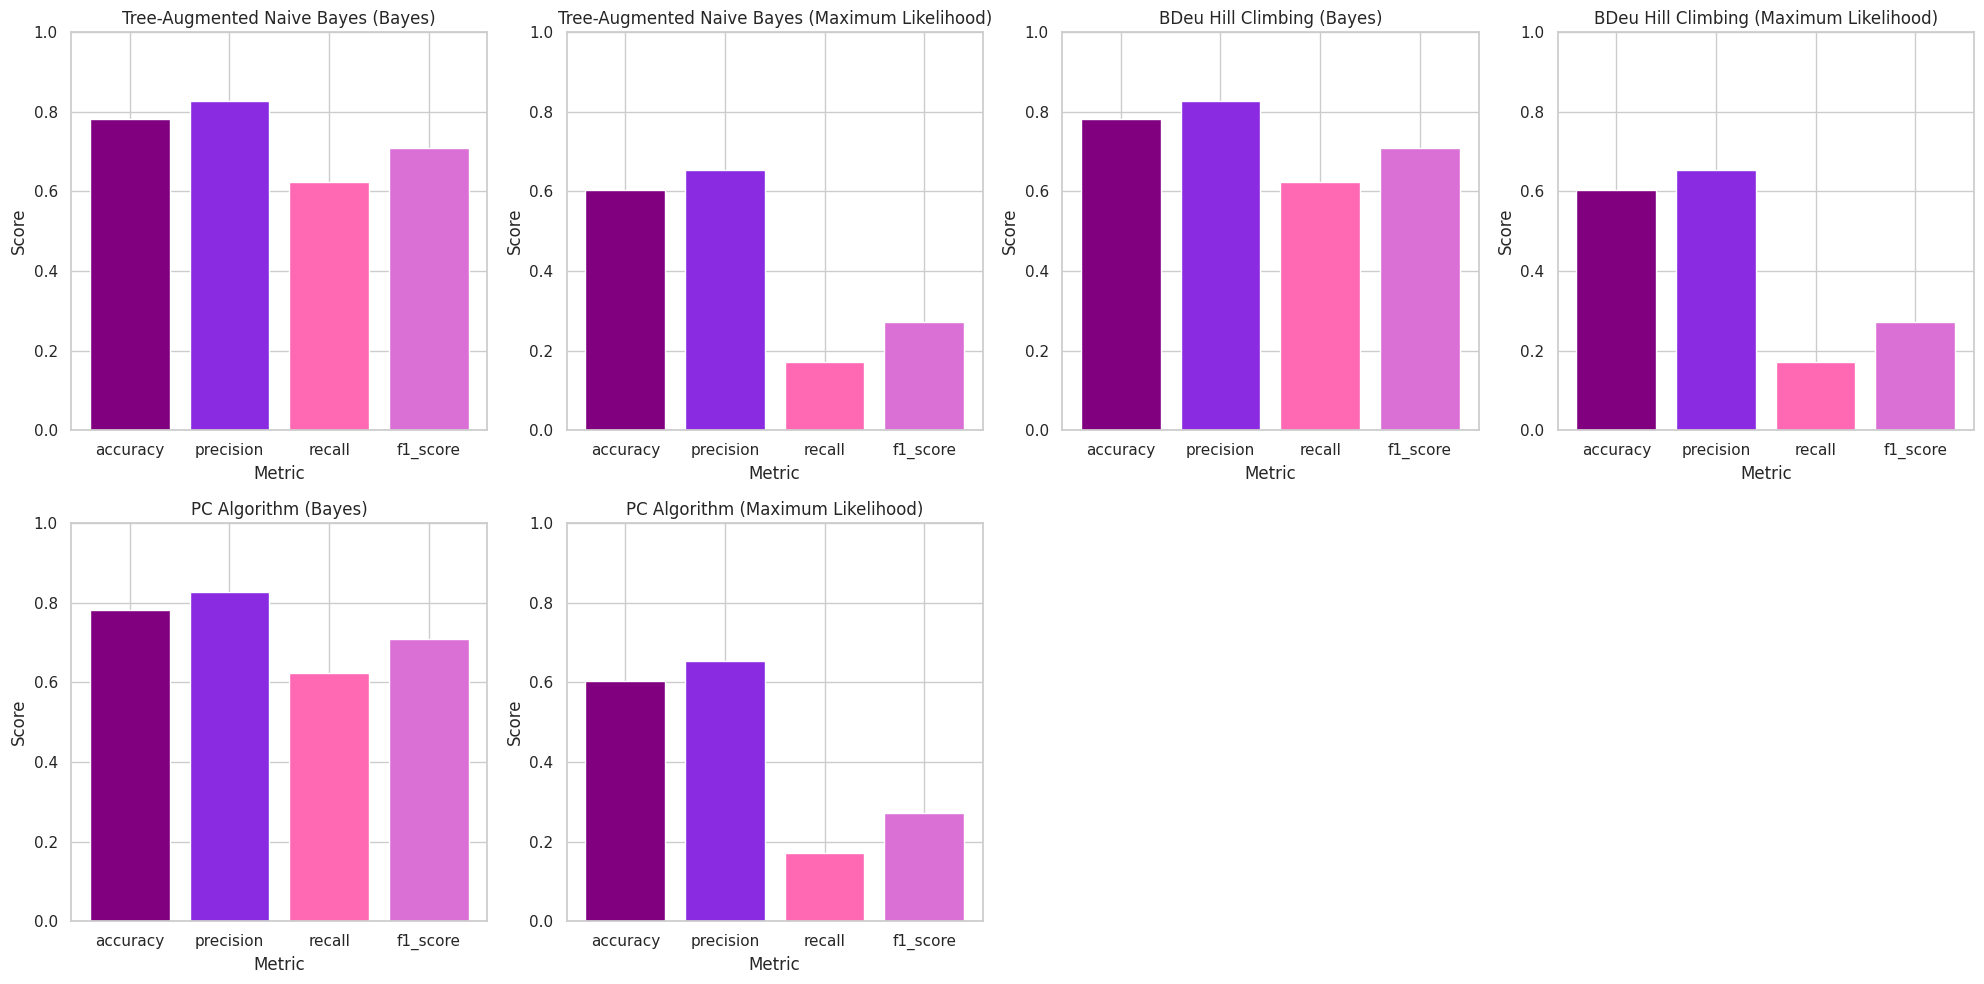

In [32]:
plot_metrics_graphs(metrics)

In [33]:
for method, metrictypes in metrics.items():
    print(f"\n{method}:")
    for metric, value in metrictypes.items():
        if metric in ['accuracy', 'precision', 'recall', 'f1_score']:
            print(f"  {metric.capitalize()}: {value * 100:.2f}%")
        else:
            print(f"  {metric.capitalize()}: {value}")


Tree-Augmented Naive Bayes (Bayes):
  Accuracy: 78.16%
  Precision: 82.72%
  Recall: 62.33%
  F1_score: 70.80%

Tree-Augmented Naive Bayes (Maximum Likelihood):
  Accuracy: 60.39%
  Precision: 65.43%
  Recall: 17.16%
  F1_score: 27.15%

BDeu Hill Climbing (Bayes):
  Accuracy: 78.16%
  Precision: 82.72%
  Recall: 62.33%
  F1_score: 70.80%

BDeu Hill Climbing (Maximum Likelihood):
  Accuracy: 60.39%
  Precision: 65.43%
  Recall: 17.16%
  F1_score: 27.15%

PC Algorithm (Bayes):
  Accuracy: 78.16%
  Precision: 82.72%
  Recall: 62.33%
  F1_score: 70.80%

PC Algorithm (Maximum Likelihood):
  Accuracy: 60.39%
  Precision: 65.43%
  Recall: 17.16%
  F1_score: 27.15%


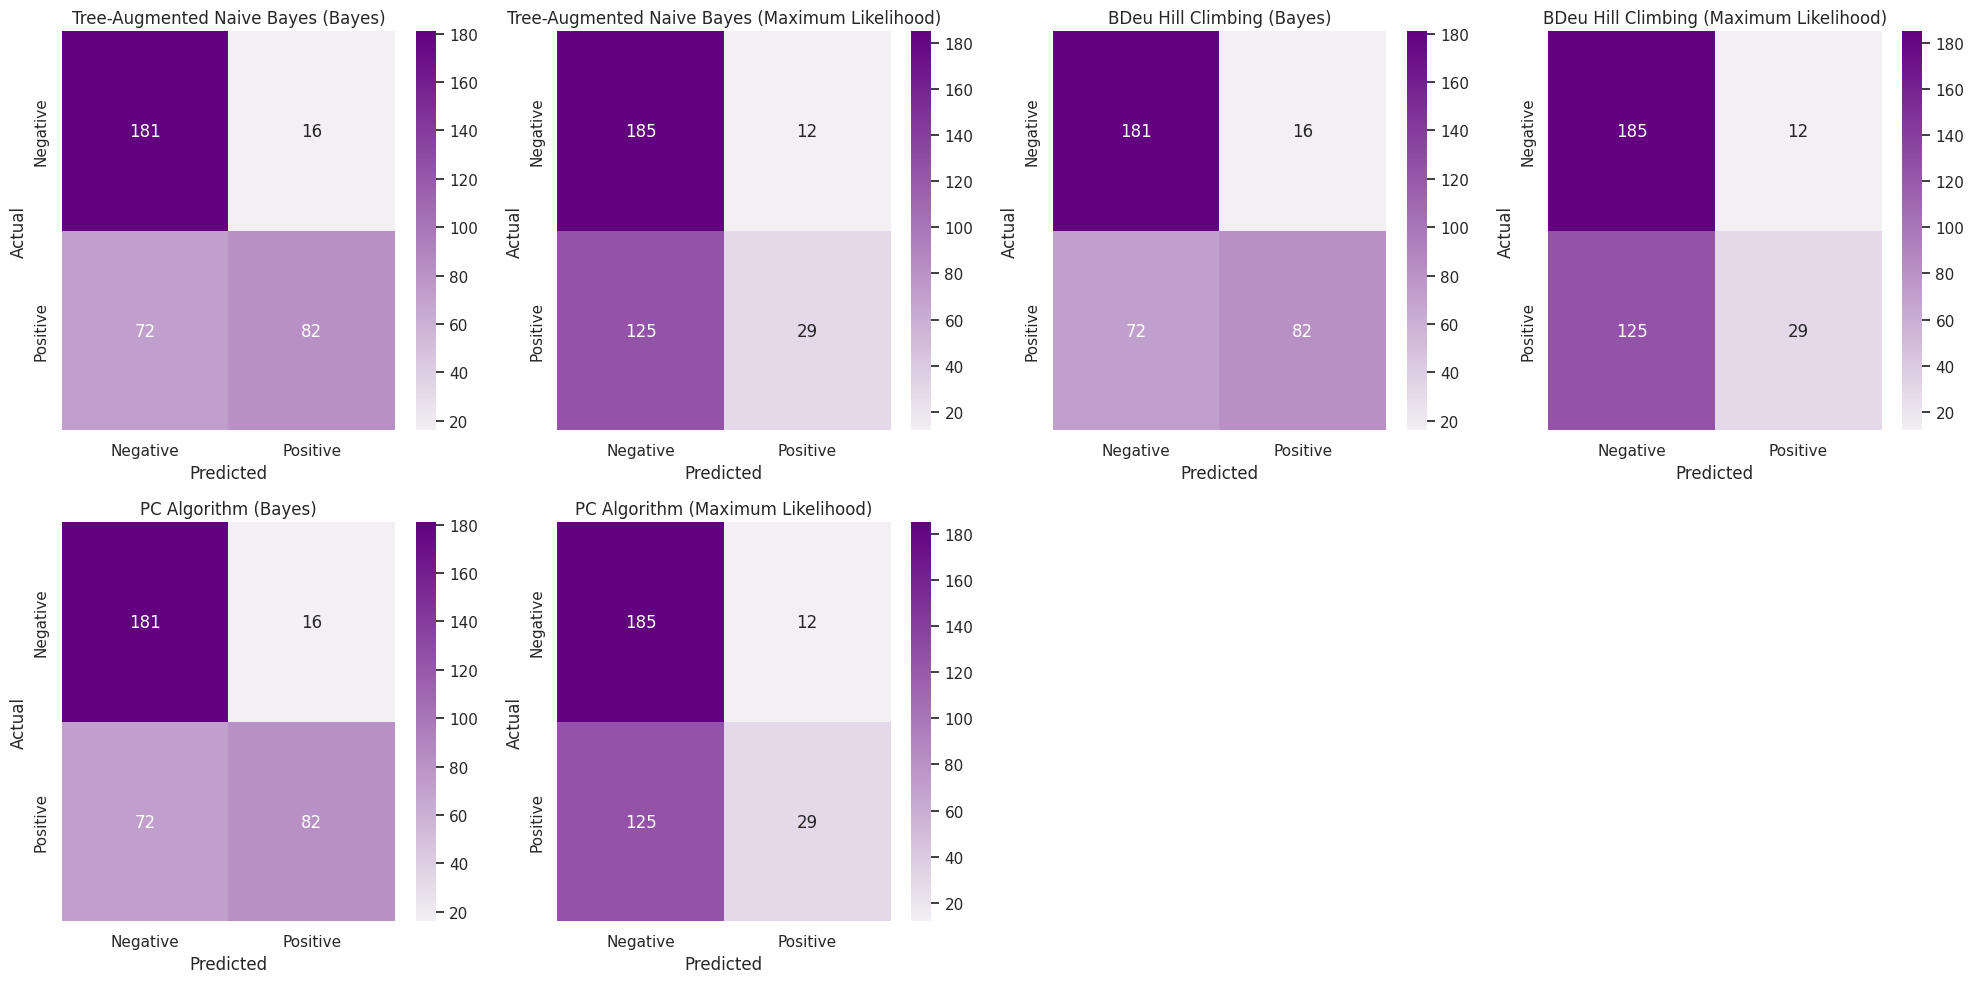

In [34]:
plot_confusion_matrices(confusion, cmap=gradient_palette)

# Parkinson's Disease
---